# Models
---
With all the data being rescraped and cleaned the way it is, we have to run new models. 

The models are working now but we will have to probably start sampling soon since the current dataframe being imported is over 2 million rows!

In [39]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_curve, recall_score, precision_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

import pickle

In [7]:
df = pd.read_csv('past_7_seasons_cleaned.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256848 entries, 0 to 2256847
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   release_speed      float64
 1   release_pos_x      float64
 2   release_pos_z      float64
 3   stand              object 
 4   p_throws           object 
 5   type               object 
 6   pfx_x              float64
 7   pfx_z              float64
 8   plate_x            float64
 9   plate_z            float64
 10  vx0                float64
 11  vy0                float64
 12  vz0                float64
 13  ax                 float64
 14  ay                 float64
 15  az                 float64
 16  release_spin_rate  float64
 17  pitch_name         object 
dtypes: float64(14), object(4)
memory usage: 309.9+ MB


In [11]:
# Make a function to do the additional cleaning that was done after saving to a csv
def post_clean(df):
    
    # Rename 'type' (our target) to 'result'
    df.rename(columns={'type':'result'}, inplace=True)
    
    # Only want results that are S or B
    df = df.loc[((df['result'] == 'S') | (df['result'] == 'B'))]
    
    # Print out Null Accuracy
    print('The Null Accuracy:')
    print(df['result'].value_counts(normalize=True))
    
    # Make 'stand','p_throws', and 'result' binary columns
    # This shows that righties (R) are 1 while lefties (L) are 0
    # As well as strikes (S) being represented as 1 and balls (B) as 0
    df['result'] = np.where(df['result'] == 'S', 1, 0)
    df['stand'] = np.where(df['stand'] == 'R', 1, 0)
    df['p_throws'] = np.where(df['p_throws'] == 'R', 1, 0)
    
    # Rename the columns
    df.rename(columns={'stand':'batter_stance','p_throws':'pitchers_throwing_hand','result':'result'},inplace=True)
    
    # We will make a copy of the dataframe to create a df to dummify the original
    df2 = df.copy()
    
    # Drop the pitch_name from df2 copy
    df2 = df2.loc[:, df2.columns != 'pitch_name']
    
    # Dummify pitch names on original df
    df = pd.get_dummies(df, columns=['pitch_name'], prefix='pitch', drop_first=True)
    
    return df, df2

In [12]:
df, df2 = post_clean(df)

The Null Accuracy:
B    0.666414
S    0.333586
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [16]:
df.result.value_counts(normalize=True)

0    0.666414
1    0.333586
Name: result, dtype: float64

In [14]:
params = ({
    'n_estimators':[100,150,200],
    'max_depth':[2,3,4,5],
    'max_features':['log2','auto']
})

In [19]:
X = df2.loc[:, df2.columns!='result'] # A matrix containing features we want
y = df2.result # A vector we are aiming for
X.head()

,release_speed,release_pos_x,release_pos_z,batter_stance,pitchers_throwing_hand,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate
0,96.1,-1.92,5.95,1,1,-0.27,1.70,-0.93,1.62,3.08,-139.61,-9.72,-2.03,34.78,-11.71,2463.0
1,93.6,-1.25,6.06,1,1,0.32,0.80,2.92,2.23,10.09,-135.73,-5.82,6.08,26.36,-24.25,2724.0
2,97.6,-1.45,6.22,0,1,-0.26,1.52,-0.85,3.15,2.00,-141.92,-6.17,-1.82,34.59,-13.48,2255.0
3,92.0,-1.77,6.12,0,1,0.23,0.80,-0.05,2.70,3.69,-133.89,-4.47,4.71,26.80,-24.40,2755.0
4,86.8,-1.56,6.08,1,1,0.28,-0.66,-0.10,1.07,2.71,-126.33,-4.10,4.71,26.40,-41.76,2498.0


In [20]:
# Use train test split to split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)

In [21]:
# Check the splits are correct
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1692633, 16), (564212, 16), (1692633,), (564212,))

In [24]:
rf = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=params,
                        n_jobs=4,
                        verbose=2,
                        random_state=66)

In [25]:
rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 35.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 54.3min finished


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'max_depth': [2, 3, 4, 5],
                                        'max_features': ['log2', 'auto'],
                                        'n_estimators': [100, 150, 200]},
                   random_state=66, verbose=2)

In [26]:
print(f'Train score: {rf.score(X_train, y_train)}')
print(f'Test score: {rf.score(X_test, y_test)}')
rf.best_params_

Train score: 0.912073674565012
Test score: 0.912290061182676


{'n_estimators': 200, 'max_features': 'auto', 'max_depth': 5}

In [27]:
preds = rf.predict(X_test)
accuracy_score(y_test, preds)

0.912290061182676

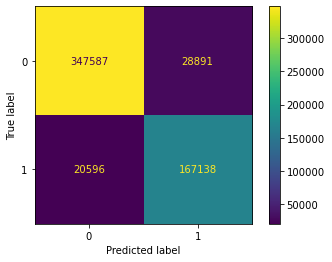

In [28]:
# Confusion Matrix
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [31]:
confusion = confusion_matrix(y_test, preds)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[347587  28891]
 [ 20596 167138]]


In [34]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(accuracy_score(y_test, preds))

0.912290061182676
0.912290061182676


This is the Classification Accuracy, how often is it correct.

---
Below is how often is it wrong, classification error.

In [36]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - accuracy_score(y_test, preds))

0.08770993881732399
0.08770993881732403


Next, we calculate sensitivity and specificity.

Sensitivity - When the actual value is positive, how often is the prediction correct?
- This needs to me maximized as much as possible
- We need true positive rate or "recall"

Specificity - When the actual value is negative, how often is the prediction correct?
- We also need to maximize on this
- How "selective" is the classifier at detecting positive instances

In [38]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(recall_score(y_test, preds))

specificity = TN / (TN + FP)

print(specificity)

0.890291582771368
0.890291582771368
0.9232597920728436


The classifer we just ran is both high in sensitivity and specificity. Meaning we are pretty accurate with our results. But considering it is not 100% shows that there is error in the classifier or that umpires are truly not perfect.

---

The last things we need are false positive rate (if the actual value is a ball, then how often are we incorrect) and precision (if the strike is predicted, how often is the prediction correct)

In [40]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

precision = TP / float(TP + FP)

print(precision)
print(precision_score(y_test, preds))

0.07674020792715644
0.07674020792715641
0.8526187451856613
0.8526187451856613


# Question

Has umpiring gotten better in making ball and strike calls? In order to answer that, we will set up a model to run on the same parameters as the one above.

In [42]:
# Import 2015 df to test it
mlb15 = pd.read_csv('train_test_2015.csv')

In [98]:
# Let's create a function that run's everything we want and then run a for function outside of it
def run_it(df, year, params, list_of_col_names=[]):
    print('\n')
    print(f'{year} MLB SEASON MODEL:')
    print('\n')
    
    # The df will be cleaned using the formula and create two df
    df1, df2 = post_clean(df)
    
    # First, determine X and y, for now we are including all stats
    print('\nWe will create a model WITHOUT pitch names.\n')
    X = df2.loc[:, df2.columns!='result']
    y = df2.result
    
    # Train test split X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)
    
    # In case it doesn't split well or the data is not good.
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Instantiate our random forest model
    rf = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=params,
                        n_jobs=6,
                        verbose=2,
                        random_state=66)
    
    # Fit it
    rf.fit(X_train, y_train)
    
    # Print out train scores and best parameters
    print(f'Train score for {year} season: {rf.score(X_train, y_train)}')
    print(f'Test score for {year} season: {rf.score(X_test, y_test)}')
    print(f'The best parameters for the model were {rf.best_params_}')
    
    # Print accuracy score
    preds = rf.predict(X_test)
    print(f'The accuracy score for {year} is {accuracy_score(y_test, preds)}')
    
    # Print the confusion Matrix
    plot_confusion_matrix(rf, X_test, y_test)
    plt.show()
    confusion = confusion_matrix(y_test, preds)
    print(confusion)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # Compare our classification accuracy and classification error
    print('\nClassification Accuracy:')
    print((TP + TN) / float(TP + TN + FP + FN))
    print(accuracy_score(y_test, preds))
    
    print('\nClassification Error:')
    print((FP + FN) / float(TP + TN + FP + FN))
    print(1 - accuracy_score(y_test, preds))
    
    # Compare Sensitivity and Specificity
    print('\nSensitivity:')
    sensitivity = TP / float(FN + TP)
    print(sensitivity)
    print(recall_score(y_test, preds))
    print('\nSpecificity:')
    specificity = TN / (TN + FP)
    print(specificity)
    
    # Determine False Positive Rate and Precision
    print('\nFalse Positivity Rate:')
    false_positive_rate = FP / float(TN + FP)
    print(false_positive_rate)
    print(1 - specificity)

    print('\nPrecision:')
    precision = TP / float(TP + FP)
    print(precision)
    print(precision_score(y_test, preds))

In [69]:
# import the rest of the data
mlb16 = pd.read_csv('train_test_2016.csv')
mlb17 = pd.read_csv('train_test_2017.csv')
mlb18 = pd.read_csv('train_test_2018.csv')
mlb19 = pd.read_csv('train_test_2019.csv')
mlb20 = pd.read_csv('train_test_2020.csv')
mlb21 = pd.read_csv('train_test_2021.csv')

In [71]:
seasons = [mlb15, mlb16, mlb17, mlb18, mlb19, mlb20, mlb21]
year = 2015
params = ({
    'n_estimators':[100,150,200,250],
    'max_depth':[2,3,4,5],
    'max_features':['log2','auto']
})



2015 MLB SEASON MODEL:


The Null Accuracy:
B    0.659733
S    0.340267
Name: result, dtype: float64

We will create a model WITHOUT pitch names.

(249064, 16) (83022, 16) (249064,) (83022,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.6min finished


Train score for 2015 season: 0.9077425882504095
Test score for 2015 season: 0.9081207390812074
The best parameters for the model were {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2015 is 0.9081207390812074


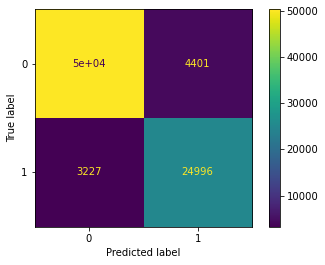

[[50398  4401]
 [ 3227 24996]]

Classification Accuracy:
0.9081207390812074
0.9081207390812074

Classification Error:
0.09187926091879262
0.09187926091879262

Sensitivity:
0.885660631399922
0.885660631399922

Specificity:
0.9196883154802095

False Positivity Rate:
0.08031168451979051
0.08031168451979054

Precision:
0.8502908460046944
0.8502908460046944


2016 MLB SEASON MODEL:


The Null Accuracy:
B    0.661719
S    0.338281
Name: result, dtype: float64

We will create a model WITHOUT pitch names.

(253597, 16) (84533, 16) (253597,) (84533,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.7min finished


Train score for 2016 season: 0.9087173744168898
Test score for 2016 season: 0.9095146274236097
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2016 is 0.9095146274236097


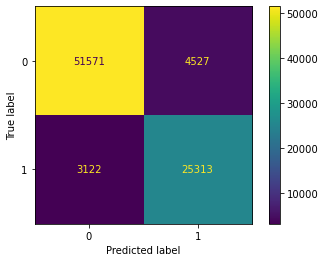

[[51571  4527]
 [ 3122 25313]]

Classification Accuracy:
0.9095146274236097
0.9095146274236097

Classification Error:
0.09048537257639029
0.09048537257639033

Sensitivity:
0.8902057323720767
0.8902057323720767

Specificity:
0.919301935897893

False Positivity Rate:
0.08069806410210703
0.080698064102107

Precision:
0.8482908847184987
0.8482908847184987


2017 MLB SEASON MODEL:


The Null Accuracy:
B    0.667877
S    0.332123
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org


We will create a model WITHOUT pitch names.

(271523, 16) (90508, 16) (271523,) (90508,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  5.1min finished


Train score for 2017 season: 0.9096614283136235
Test score for 2017 season: 0.9103062712688381
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2017 is 0.9103062712688381


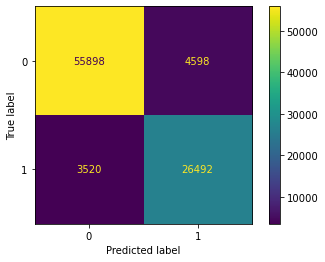

[[55898  4598]
 [ 3520 26492]]

Classification Accuracy:
0.9103062712688381
0.9103062712688381

Classification Error:
0.08969372873116188
0.08969372873116188

Sensitivity:
0.882713581234173
0.882713581234173

Specificity:
0.9239949748743719

False Positivity Rate:
0.07600502512562814
0.07600502512562812

Precision:
0.8521067867481505
0.8521067867481505


2018 MLB SEASON MODEL:


The Null Accuracy:
B    0.665881
S    0.334119
Name: result, dtype: float64

We will create a model WITHOUT pitch names.

(271591, 16) (90531, 16) (271591,) (90531,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  5.3min finished


Train score for 2018 season: 0.914249735815988
Test score for 2018 season: 0.9137091162143354
The best parameters for the model were {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2018 is 0.9137091162143354


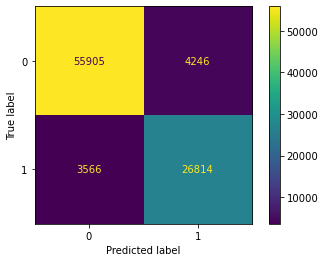

[[55905  4246]
 [ 3566 26814]]

Classification Accuracy:
0.9137091162143354
0.9137091162143354

Classification Error:
0.08629088378566457
0.08629088378566463

Sensitivity:
0.8826201448321264
0.8826201448321264

Specificity:
0.929410982361058

False Positivity Rate:
0.070589017638942
0.07058901763894199

Precision:
0.8632968448164843
0.8632968448164843


2019 MLB SEASON MODEL:


The Null Accuracy:
B    0.671056
S    0.328944
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org


We will create a model WITHOUT pitch names.

(272889, 16) (90963, 16) (272889,) (90963,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  5.2min finished


Train score for 2019 season: 0.9176185188849679
Test score for 2019 season: 0.9179336653364555
The best parameters for the model were {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2019 is 0.9179336653364555


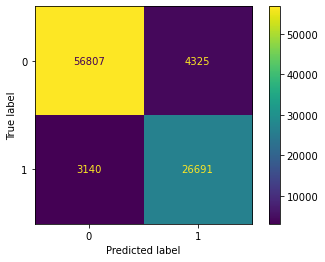

[[56807  4325]
 [ 3140 26691]]

Classification Accuracy:
0.9179336653364555
0.9179336653364555

Classification Error:
0.08206633466354452
0.08206633466354452

Sensitivity:
0.8947403707552546
0.8947403707552546

Specificity:
0.9292514558659949

False Positivity Rate:
0.07074854413400511
0.07074854413400511

Precision:
0.8605558421459891
0.8605558421459891


2020 MLB SEASON MODEL:


The Null Accuracy:
B    0.669815
S    0.330185
Name: result, dtype: float64

We will create a model WITHOUT pitch names.

(106183, 16) (35395, 16) (106183,) (35395,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   47.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  1.8min finished


Train score for 2020 season: 0.9189324091427065
Test score for 2020 season: 0.9197061731883034
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2020 is 0.9197061731883034


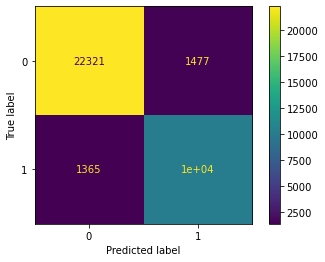

[[22321  1477]
 [ 1365 10232]]

Classification Accuracy:
0.9197061731883034
0.9197061731883034

Classification Error:
0.08029382681169657
0.08029382681169661

Sensitivity:
0.8822971458135724
0.8822971458135724

Specificity:
0.9379359610051264

False Positivity Rate:
0.06206403899487352
0.06206403899487356

Precision:
0.8738577162866171
0.8738577162866171


2021 MLB SEASON MODEL:


The Null Accuracy:
B    0.670057
S    0.329943
Name: result, dtype: float64

We will create a model WITHOUT pitch names.

(267784, 16) (89262, 16) (267784,) (89262,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  5.1min finished


Train score for 2021 season: 0.9203686553341499
Test score for 2021 season: 0.9195514328605677
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2021 is 0.9195514328605677


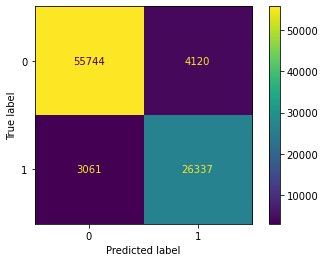

[[55744  4120]
 [ 3061 26337]]

Classification Accuracy:
0.9195514328605677
0.9195514328605677

Classification Error:
0.08044856713943223
0.08044856713943227

Sensitivity:
0.8958772705626233
0.8958772705626233

Specificity:
0.9311773352933316

False Positivity Rate:
0.06882266470666845
0.06882266470666842

Precision:
0.8647273204846176
0.8647273204846176


In [72]:
for szn in seasons:
    run_it(szn, year, params)
    year += 1

In [75]:
def run_it2(df, year, params, list_of_col_names=[]):
    print('\n')
    print(f'{year} MLB SEASON MODEL:')
    print('\n')
    
    # The df will be cleaned using the formula and create two df
    df1, df2 = post_clean(df)
    
    # First, determine X and y, for now we are including all stats
    print('\nWe will create a model WITH pitch names.\n')
    X = df1.loc[:, df1.columns!='result']
    y = df1.result
    
    # Train test split X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)
    
    # In case it doesn't split well or the data is not good.
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Instantiate our random forest model
    rf = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=params,
                        n_jobs=6,
                        verbose=2,
                        random_state=66)
    
    # Fit it
    rf.fit(X_train, y_train)
    
    # Print out train scores and best parameters
    print(f'Train score for {year} season: {rf.score(X_train, y_train)}')
    print(f'Test score for {year} season: {rf.score(X_test, y_test)}')
    print(f'The best parameters for the model were {rf.best_params_}')
    
    # Print accuracy score
    preds = rf.predict(X_test)
    print(f'The accuracy score for {year} is {accuracy_score(y_test, preds)}')
    
    # Print the confusion Matrix
    plot_confusion_matrix(rf, X_test, y_test)
    plt.show()
    confusion = confusion_matrix(y_test, preds)
    print(confusion)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # Compare our classification accuracy and classification error
    print('\nClassification Accuracy:')
    print((TP + TN) / float(TP + TN + FP + FN))
    print(accuracy_score(y_test, preds))
    
    print('\nClassification Error:')
    print((FP + FN) / float(TP + TN + FP + FN))
    print(1 - accuracy_score(y_test, preds))
    
    # Compare Sensitivity and Specificity
    print('\nSensitivity:')
    sensitivity = TP / float(FN + TP)
    print(sensitivity)
    print(recall_score(y_test, preds))
    print('\nSpecificity:')
    specificity = TN / (TN + FP)
    print(specificity)
    
    # Determine False Positive Rate and Precision
    print('\nFalse Positivity Rate:')
    false_positive_rate = FP / float(TN + FP)
    print(false_positive_rate)
    print(1 - specificity)

    print('\nPrecision:')
    precision = TP / float(TP + FP)
    print(precision)
    print(precision_score(y_test, preds))

## Run models knowing the pitch name

---


In [76]:
seasons = [mlb15, mlb16, mlb17, mlb18, mlb19, mlb20, mlb21]
year = 2015
params = ({
    'n_estimators':[100,150,200,250],
    'max_depth':[2,3,4,5],
    'max_features':['log2','auto']
})



2015 MLB SEASON MODEL:


The Null Accuracy:
B    0.659733
S    0.340267
Name: result, dtype: float64

We will create a model WITH pitch names.

(249064, 28) (83022, 28) (249064,) (83022,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.1min finished


Train score for 2015 season: 0.8653719525904988
Test score for 2015 season: 0.8647346486473465
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2015 is 0.8647346486473465


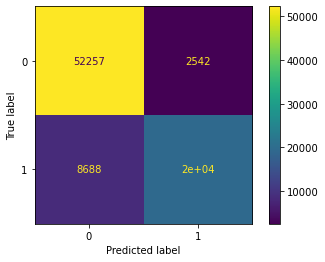

[[52257  2542]
 [ 8688 19535]]

Classification Accuracy:
0.8647346486473465
0.8647346486473465

Classification Error:
0.13526535135265352
0.1352653513526535

Sensitivity:
0.6921659639301279
0.6921659639301279

Specificity:
0.953612292195113

False Positivity Rate:
0.04638770780488695
0.04638770780488699

Precision:
0.8848575440503692
0.8848575440503692


2016 MLB SEASON MODEL:


The Null Accuracy:
B    0.661719
S    0.338281
Name: result, dtype: float64

We will create a model WITH pitch names.

(253597, 27) (84533, 27) (253597,) (84533,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.0min finished


Train score for 2016 season: 0.8619423731353288
Test score for 2016 season: 0.8608235836892101
The best parameters for the model were {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2016 is 0.8608235836892101


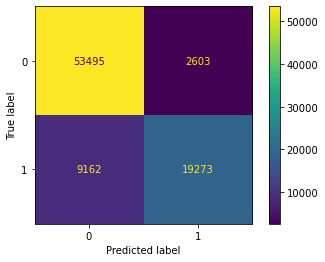

[[53495  2603]
 [ 9162 19273]]

Classification Accuracy:
0.8608235836892101
0.8608235836892101

Classification Error:
0.13917641631078986
0.13917641631078992

Sensitivity:
0.6777914541937753
0.6777914541937753

Specificity:
0.9535990587899746

False Positivity Rate:
0.04640094121002531
0.04640094121002536

Precision:
0.8810111537758274
0.8810111537758274


2017 MLB SEASON MODEL:


The Null Accuracy:
B    0.667877
S    0.332123
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org


We will create a model WITH pitch names.

(271523, 28) (90508, 28) (271523,) (90508,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  4.0min finished


Train score for 2017 season: 0.829896546517238
Test score for 2017 season: 0.8298382463428647
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2017 is 0.8298382463428647


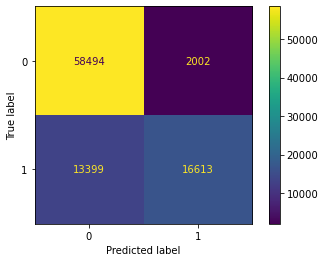

[[58494  2002]
 [13399 16613]]

Classification Accuracy:
0.8298382463428647
0.8298382463428647

Classification Error:
0.1701617536571353
0.17016175365713526

Sensitivity:
0.5535452485672397
0.5535452485672397

Specificity:
0.9669069029357313

False Positivity Rate:
0.03309309706426871
0.03309309706426866

Precision:
0.8924523233951115
0.8924523233951115


2018 MLB SEASON MODEL:


The Null Accuracy:
B    0.665881
S    0.334119
Name: result, dtype: float64

We will create a model WITH pitch names.

(271591, 28) (90531, 28) (271591,) (90531,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  4.0min finished


Train score for 2018 season: 0.8747417992496069
Test score for 2018 season: 0.8736565375396274
The best parameters for the model were {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2018 is 0.8736565375396274


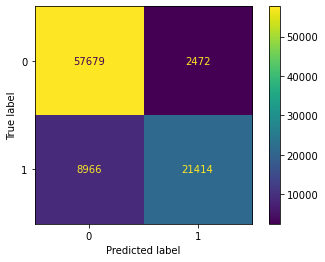

[[57679  2472]
 [ 8966 21414]]

Classification Accuracy:
0.8736565375396274
0.8736565375396274

Classification Error:
0.1263434624603727
0.12634346246037265

Sensitivity:
0.7048716260697827
0.7048716260697827

Specificity:
0.9589034263769514

False Positivity Rate:
0.04109657362304866
0.04109657362304864

Precision:
0.8965084149711128
0.8965084149711128


2019 MLB SEASON MODEL:


The Null Accuracy:
B    0.671056
S    0.328944
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org


We will create a model WITH pitch names.

(272889, 27) (90963, 27) (272889,) (90963,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  4.0min finished


Train score for 2019 season: 0.8938359552785199
Test score for 2019 season: 0.8932093268691665
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2019 is 0.8932093268691665


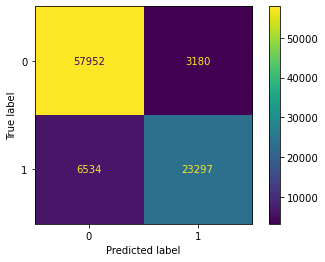

[[57952  3180]
 [ 6534 23297]]

Classification Accuracy:
0.8932093268691665
0.8932093268691665

Classification Error:
0.10679067313083342
0.10679067313083346

Sensitivity:
0.7809661090811572
0.7809661090811572

Specificity:
0.9479814172610089

False Positivity Rate:
0.052018582738991036
0.05201858273899107

Precision:
0.879895758582921
0.879895758582921


2020 MLB SEASON MODEL:


The Null Accuracy:
B    0.669815
S    0.330185
Name: result, dtype: float64

We will create a model WITH pitch names.

(106183, 26) (35395, 26) (106183,) (35395,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   37.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  1.4min finished


Train score for 2020 season: 0.8771743122722093
Test score for 2020 season: 0.8731459245656166
The best parameters for the model were {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2020 is 0.8731459245656166


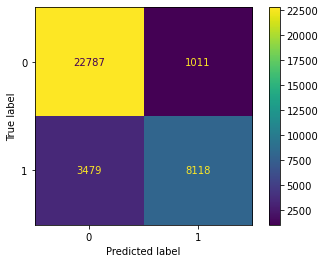

[[22787  1011]
 [ 3479  8118]]

Classification Accuracy:
0.8731459245656166
0.8731459245656166

Classification Error:
0.1268540754343834
0.12685407543438343

Sensitivity:
0.7000086229197207
0.7000086229197207

Specificity:
0.9575174384402051

False Positivity Rate:
0.04248256155979494
0.04248256155979491

Precision:
0.8892540256325994
0.8892540256325994


2021 MLB SEASON MODEL:


The Null Accuracy:
B    0.670057
S    0.329943
Name: result, dtype: float64

We will create a model WITH pitch names.

(267784, 26) (89262, 26) (267784,) (89262,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  4.2min finished


Train score for 2021 season: 0.8902772383712245
Test score for 2021 season: 0.8882951311868432
The best parameters for the model were {'n_estimators': 250, 'max_features': 'auto', 'max_depth': 5}
The accuracy score for 2021 is 0.8882951311868432


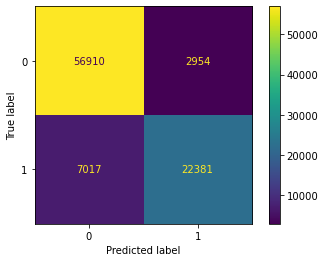

[[56910  2954]
 [ 7017 22381]]

Classification Accuracy:
0.8882951311868432
0.8882951311868432

Classification Error:
0.11170486881315678
0.11170486881315678

Sensitivity:
0.7613102932172257
0.7613102932172257

Specificity:
0.9506548175865295

False Positivity Rate:
0.04934518241347053
0.04934518241347052

Precision:
0.8834024077363332
0.8834024077363332


In [77]:
for szn in seasons:
    run_it2(szn, year, params)
    year += 1

In [78]:
df15_1, df15_2 = post_clean(mlb15)
df15_1.head(3)

The Null Accuracy:
B    0.659733
S    0.340267
Name: result, dtype: float64


,release_speed,release_pos_x,release_pos_z,batter_stance,pitchers_throwing_hand,result,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Eephus,pitch_Fastball,pitch_Forkball,pitch_Knuckle Curve,pitch_Knuckleball,pitch_Screwball,pitch_Sinker,pitch_Slider,pitch_Split-Finger
0,96.1,-1.92,5.95,1,1,1,-0.27,1.70,-0.93,1.62,3.08,-139.61,-9.72,-2.03,34.78,-11.71,2463.0,0,0,0,0,0,0,0,0,0,0,0,0
1,93.6,-1.25,6.06,1,1,0,0.32,0.80,2.92,2.23,10.09,-135.73,-5.82,6.08,26.36,-24.25,2724.0,0,0,1,0,0,0,0,0,0,0,0,0
2,97.6,-1.45,6.22,0,1,0,-0.26,1.52,-0.85,3.15,2.00,-141.92,-6.17,-1.82,34.59,-13.48,2255.0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
df15_2.head(3)

,release_speed,release_pos_x,release_pos_z,batter_stance,pitchers_throwing_hand,result,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate
0,96.1,-1.92,5.95,1,1,1,-0.27,1.70,-0.93,1.62,3.08,-139.61,-9.72,-2.03,34.78,-11.71,2463.0
1,93.6,-1.25,6.06,1,1,0,0.32,0.80,2.92,2.23,10.09,-135.73,-5.82,6.08,26.36,-24.25,2724.0
2,97.6,-1.45,6.22,0,1,0,-0.26,1.52,-0.85,3.15,2.00,-141.92,-6.17,-1.82,34.59,-13.48,2255.0


In [80]:
mlb15.head(3)

,release_speed,release_pos_x,release_pos_z,stand,p_throws,result,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,pitch_name
0,96.1,-1.92,5.95,R,R,S,-0.27,1.70,-0.93,1.62,3.08,-139.61,-9.72,-2.03,34.78,-11.71,2463.0,4-Seam Fastball
1,93.6,-1.25,6.06,R,R,B,0.32,0.80,2.92,2.23,10.09,-135.73,-5.82,6.08,26.36,-24.25,2724.0,Cutter
2,97.6,-1.45,6.22,L,R,B,-0.26,1.52,-0.85,3.15,2.00,-141.92,-6.17,-1.82,34.59,-13.48,2255.0,4-Seam Fastball


## Random Forest Model including pitch names

In [84]:
# We will run a random forest model on the pitch names on the entire data set
X2 = df.loc[:, df.columns!='result'] # A matrix containing features we want
y2 = df.result # A vector we are aiming for
X2.head()

,release_speed,release_pos_x,release_pos_z,batter_stance,pitchers_throwing_hand,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Eephus,pitch_Fastball,pitch_Forkball,pitch_Knuckle Curve,pitch_Knuckleball,pitch_Screwball,pitch_Sinker,pitch_Slider,pitch_Split-Finger
0,96.1,-1.92,5.95,1,1,-0.27,1.70,-0.93,1.62,3.08,-139.61,-9.72,-2.03,34.78,-11.71,2463.0,0,0,0,0,0,0,0,0,0,0,0,0
1,93.6,-1.25,6.06,1,1,0.32,0.80,2.92,2.23,10.09,-135.73,-5.82,6.08,26.36,-24.25,2724.0,0,0,1,0,0,0,0,0,0,0,0,0
2,97.6,-1.45,6.22,0,1,-0.26,1.52,-0.85,3.15,2.00,-141.92,-6.17,-1.82,34.59,-13.48,2255.0,0,0,0,0,0,0,0,0,0,0,0,0
3,92.0,-1.77,6.12,0,1,0.23,0.80,-0.05,2.70,3.69,-133.89,-4.47,4.71,26.80,-24.40,2755.0,0,0,1,0,0,0,0,0,0,0,0,0
4,86.8,-1.56,6.08,1,1,0.28,-0.66,-0.10,1.07,2.71,-126.33,-4.10,4.71,26.40,-41.76,2498.0,0,0,0,0,0,0,1,0,0,0,0,0


In [85]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=66)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1692633, 16), (564212, 16), (1692633,), (564212,))

In [88]:
rf2 = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=params,
                        n_jobs=6,
                        verbose=2,
                        random_state=66)

In [89]:
rf2.fit(X2_train, y2_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed: 34.6min finished


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=6,
                   param_distributions={'max_depth': [2, 3, 4, 5],
                                        'max_features': ['log2', 'auto'],
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=66, verbose=2)

In [90]:
print(f'Train score: {rf2.score(X2_train, y2_train)}')
print(f'Test score: {rf2.score(X2_test, y2_test)}')
rf2.best_params_

Train score: 0.8343846539681077
Test score: 0.834489518124393


{'n_estimators': 150, 'max_features': 'auto', 'max_depth': 5}

In [91]:
preds2 = rf2.predict(X2_test)
accuracy_score(y2_test, preds2)

0.834489518124393

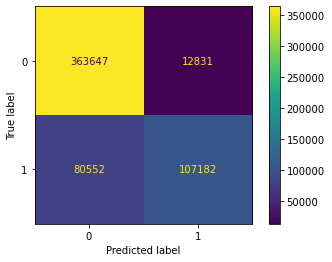

[[363647  12831]
 [ 80552 107182]]

Classification Accuracy:
0.834489518124393
0.834489518124393

Classification Error:
0.16551048187560705
0.16551048187560702

Sensitivity:
0.5709248191590228
0.5709248191590228

Specificity:
0.9659183272329326

False Positivity Rate:
0.034081672767067396
0.03408167276706742

Precision:
0.893086582286919
0.893086582286919


In [92]:
plot_confusion_matrix(rf2, X2_test, y2_test)
plt.show()

confusion2 = confusion_matrix(y2_test, preds2)
print(confusion2)
TP = confusion2[1, 1]
TN = confusion2[0, 0]
FP = confusion2[0, 1]
FN = confusion2[1, 0]

# Compare our classification accuracy and classification error
print('\nClassification Accuracy:')
print((TP + TN) / float(TP + TN + FP + FN))
print(accuracy_score(y2_test, preds2))

print('\nClassification Error:')
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - accuracy_score(y2_test, preds2))

# Compare Sensitivity and Specificity
print('\nSensitivity:')
sensitivity2 = TP / float(FN + TP)
print(sensitivity2)
print(recall_score(y2_test, preds2))
print('\nSpecificity:')
specificity2 = TN / (TN + FP)
print(specificity2)

# Determine False Positive Rate and Precision
print('\nFalse Positivity Rate:')
false_positive_rate2 = FP / float(TN + FP)
print(false_positive_rate2)
print(1 - specificity2)

print('\nPrecision:')
precision2 = TP / float(TP + FP)
print(precision2)
print(precision_score(y2_test, preds2))

# Let's run on features we want:

In [113]:
def rf_custom(df, year, params, features=[], options='without'):
    print('\n')
    print(f'{year} MLB SEASON MODEL:')
    print('\n')
    
    # The df will be cleaned using the formula and create two df
    df1, df2 = post_clean(df)
    
    # First, determine X and y, for now we are including all stats
    if options == 'without':
        print('\nWe will create a model WITHOUT pitch names.\n')
        X = df2.loc[:, df2.columns!='result']
        y = df2.result
    if options == 'with':
        print('\nWe will create a model WITH pitch names.\n')
        X = df1.loc[:, df1.columns!='result']
        y = df1.result
    
    # We must reclean the data in order to achieve the results we want
    if options == 'custom':
        print('\nWe will create a model WITH CUSTOM SELECTION OF FEATURES.\n')
        # Rename 'type' (our target) to 'result'
        df.rename(columns={'type':'result'}, inplace=True)
        # Only want results that are S or B
        df = df.loc[((df['result'] == 'S') | (df['result'] == 'B'))]
        # Make columns Binary
        df['result'] = np.where(df['result'] == 'S', 1, 0)
        df['stand'] = np.where(df['stand'] == 'R', 1, 0)
        df['p_throws'] = np.where(df['p_throws'] == 'R', 1, 0)
        # Dummify pitch_name
        df = pd.get_dummies(df, columns=['pitch_name'], prefix='pitch', drop_first=True)
        
        X = df[features]
        y = df.result
        
    # Train test split X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)
    
    # In case it doesn't split well or the data is not good.
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Instantiate our random forest model
    rf = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=params,
                        n_jobs=6,
                        verbose=2,
                        random_state=66)
    
    # Fit it
    rf.fit(X_train, y_train)
    
    # Print out train scores and best parameters
    print(f'Train score for {year} season: {rf.score(X_train, y_train)}')
    print(f'Test score for {year} season: {rf.score(X_test, y_test)}')
    print(f'The best parameters for the model were {rf.best_params_}')
    
    # Print accuracy score
    preds = rf.predict(X_test)
    print(f'The accuracy score for {year} is {accuracy_score(y_test, preds)}')
    
    # Print the confusion Matrix
    plot_confusion_matrix(rf, X_test, y_test)
    plt.show()
    confusion = confusion_matrix(y_test, preds)
    print(confusion)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # Compare our classification accuracy and classification error
    print('\nClassification Accuracy:')
    print((TP + TN) / float(TP + TN + FP + FN))
    print(accuracy_score(y_test, preds))
    
    print('\nClassification Error:')
    print((FP + FN) / float(TP + TN + FP + FN))
    print(1 - accuracy_score(y_test, preds))
    
    # Compare Sensitivity and Specificity
    print('\nSensitivity:')
    sensitivity = TP / float(FN + TP)
    print(sensitivity)
    print(recall_score(y_test, preds))
    print('\nSpecificity:')
    specificity = TN / (TN + FP)
    print(specificity)
    
    # Determine False Positive Rate and Precision
    print('\nFalse Positivity Rate:')
    false_positive_rate = FP / float(TN + FP)
    print(false_positive_rate)
    print(1 - specificity)

    print('\nPrecision:')
    precision = TP / float(TP + FP)
    print(precision)
    print(precision_score(y_test, preds))

With the formula above we can now execute any random forest that we need based on any parameters we could look into.

In [102]:
mlb15.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'stand', 'p_throws',
       'result', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'release_spin_rate', 'pitch_name'],
      dtype='object')

In [109]:
seasons = [mlb15, mlb16, mlb17, mlb18, mlb19, mlb20, mlb21]
year = 2015
params = ({
    'n_estimators':[100,150,200,250],
    'max_depth':[2,3,4,5,None],
    'min_samples_split':[2,3,4],
    'max_features':['log2','auto']
})

The models below are based solely on where the pitch ended up after being thrown based on catcher's perspective.
******************************


2015 MLB SEASON MODEL:


The Null Accuracy:
B    0.659733
S    0.340267
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(249064, 4) (83022, 4) (249064,) (83022,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  2.8min finished


Train score for 2015 season: 0.9989119262518871
Test score for 2015 season: 0.9078557490785575
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2015 is 0.9078557490785575


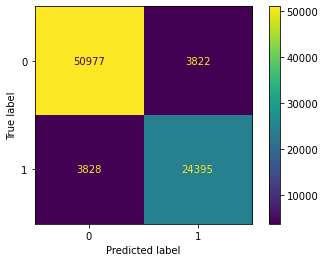

[[50977  3822]
 [ 3828 24395]]

Classification Accuracy:
0.9078557490785575
0.9078557490785575

Classification Error:
0.0921442509214425
0.09214425092144252

Sensitivity:
0.8643659426708713
0.8643659426708713

Specificity:
0.9302542017190095

False Positivity Rate:
0.06974579828099053
0.06974579828099048

Precision:
0.8645497395187298
0.8645497395187298


2016 MLB SEASON MODEL:


The Null Accuracy:
B    0.661719
S    0.338281
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(253597, 4) (84533, 4) (253597,) (84533,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  2.9min finished


Train score for 2016 season: 0.9988091341774548
Test score for 2016 season: 0.9097630511161322
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2016 is 0.9097630511161322


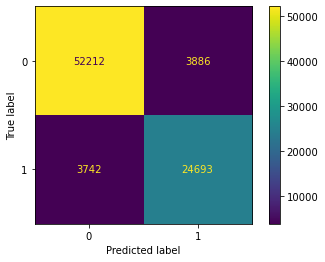

[[52212  3886]
 [ 3742 24693]]

Classification Accuracy:
0.9097630511161322
0.9097630511161322

Classification Error:
0.09023694888386784
0.0902369488838678

Sensitivity:
0.8684016177246351
0.8684016177246351

Specificity:
0.9307283682127705

False Positivity Rate:
0.06927163178722949
0.0692716317872295

Precision:
0.8640260331012282
0.8640260331012282


2017 MLB SEASON MODEL:


The Null Accuracy:
B    0.667877
S    0.332123
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.



<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

(271523, 4) (90508, 4) (271523,) (90508,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.1min finished


Train score for 2017 season: 0.998718340619395
Test score for 2017 season: 0.9102510275334778
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2017 is 0.9102510275334778


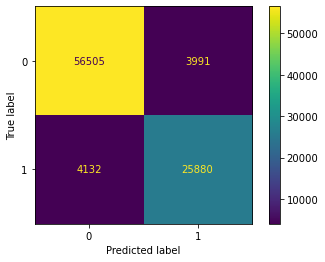

[[56505  3991]
 [ 4132 25880]]

Classification Accuracy:
0.9102510275334778
0.9102510275334778

Classification Error:
0.0897489724665223
0.08974897246652225

Sensitivity:
0.862321737971478
0.862321737971478

Specificity:
0.9340286961121397

False Positivity Rate:
0.06597130388786035
0.06597130388786032

Precision:
0.8663921529242409
0.8663921529242409


2018 MLB SEASON MODEL:


The Null Accuracy:
B    0.665881
S    0.334119
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(271591, 4) (90531, 4) (271591,) (90531,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.0min finished


Train score for 2018 season: 0.9989469459591813
Test score for 2018 season: 0.9152776397035269
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2018 is 0.9152776397035269


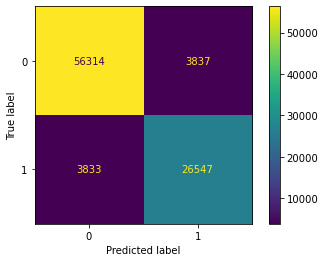

[[56314  3837]
 [ 3833 26547]]

Classification Accuracy:
0.9152776397035269
0.9152776397035269

Classification Error:
0.08472236029647304
0.08472236029647306

Sensitivity:
0.8738314680710995
0.8738314680710995

Specificity:
0.9362105368156806

False Positivity Rate:
0.06378946318431947
0.06378946318431944

Precision:
0.873716429699842
0.873716429699842


2019 MLB SEASON MODEL:


The Null Accuracy:
B    0.671056
S    0.328944
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.



<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

(272889, 4) (90963, 4) (272889,) (90963,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.0min finished


Train score for 2019 season: 0.9988823294453056
Test score for 2019 season: 0.9183624110902235
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2019 is 0.9183624110902235


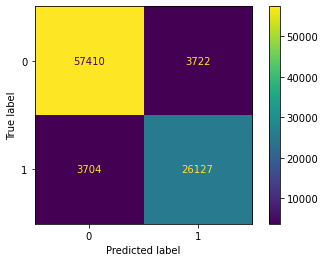

[[57410  3722]
 [ 3704 26127]]

Classification Accuracy:
0.9183624110902235
0.9183624110902235

Classification Error:
0.0816375889097765
0.08163758890977646

Sensitivity:
0.8758338641011029
0.8758338641011029

Specificity:
0.9391153569325394

False Positivity Rate:
0.060884643067460574
0.06088464306746055

Precision:
0.875305705383765
0.875305705383765


2020 MLB SEASON MODEL:


The Null Accuracy:
B    0.669815
S    0.330185
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(106183, 4) (35395, 4) (106183,) (35395,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   46.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  1.1min finished


Train score for 2020 season: 0.9991524066941035
Test score for 2020 season: 0.9195084051419692
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2020 is 0.9195084051419692


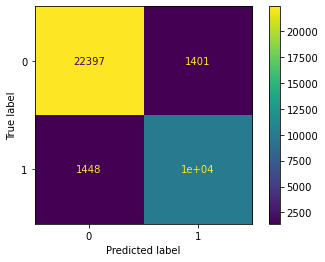

[[22397  1401]
 [ 1448 10149]]

Classification Accuracy:
0.9195084051419692
0.9195084051419692

Classification Error:
0.0804915948580308
0.08049159485803081

Sensitivity:
0.87514012244546
0.87514012244546

Specificity:
0.9411295066812337

False Positivity Rate:
0.05887049331876628
0.05887049331876626

Precision:
0.8787012987012986
0.8787012987012986


2021 MLB SEASON MODEL:


The Null Accuracy:
B    0.670057
S    0.329943
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(267784, 4) (89262, 4) (267784,) (89262,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.1min finished


Train score for 2021 season: 0.9989655842021928
Test score for 2021 season: 0.9207949631422105
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2021 is 0.9207949631422105


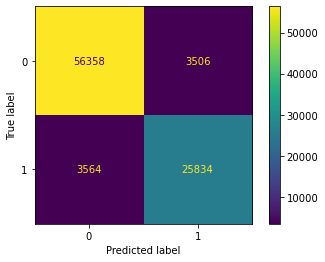

[[56358  3506]
 [ 3564 25834]]

Classification Accuracy:
0.9207949631422105
0.9207949631422105

Classification Error:
0.07920503685778943
0.07920503685778946

Sensitivity:
0.878767263079121
0.878767263079121

Specificity:
0.9414339168782574

False Positivity Rate:
0.058566083121742614
0.05856608312174261

Precision:
0.8805044308111792
0.8805044308111792


In [111]:
print('The models below are based solely on where the pitch ended up after being thrown based on catcher\'s perspective.')
print('*'*30)
for szn in seasons:
    rf_custom(szn, year, params, features=['pfx_x', 'pfx_z', 'plate_x', 'plate_z'], options='custom')
    year += 1



2015 MLB SEASON MODEL:


The Null Accuracy:
B    0.659733
S    0.340267
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(249064, 2) (83022, 2) (249064,) (83022,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   35.2s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   49.3s finished


Train score for 2015 season: 0.6596256383901327
Test score for 2015 season: 0.6600539616005396
The best parameters for the model were {'n_estimators': 250, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 3}
The accuracy score for 2015 is 0.6600539616005396


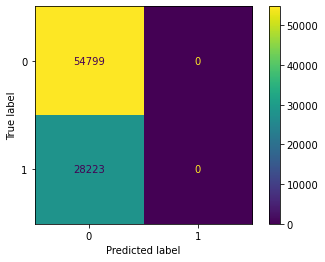

[[54799     0]
 [28223     0]]

Classification Accuracy:
0.6600539616005396
0.6600539616005396

Classification Error:
0.33994603839946036
0.33994603839946036

Sensitivity:
0.0
0.0

Specificity:
1.0

False Positivity Rate:
0.0
0.0

Precision:
nan
0.0


2016 MLB SEASON MODEL:


The Null Accuracy:
B    0.661719
S    0.338281
Name: result, dtype: float64

<ipython-input-113-14459e878ae4>:96: RuntimeWarning: invalid value encountered in true_divide
  precision = TP / float(TP + FP)
C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




We will create a model WITH CUSTOM SELECTION OF FEATURES.

(253597, 2) (84533, 2) (253597,) (84533,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   32.5s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   47.1s finished


Train score for 2016 season: 0.6610843188208062
Test score for 2016 season: 0.663622490624963
The best parameters for the model were {'n_estimators': 250, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 3}
The accuracy score for 2016 is 0.663622490624963


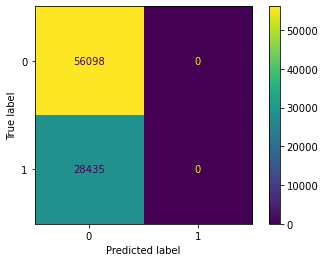

[[56098     0]
 [28435     0]]

Classification Accuracy:
0.663622490624963
0.663622490624963

Classification Error:
0.33637750937503696
0.33637750937503696

Sensitivity:
0.0
0.0

Specificity:
1.0

False Positivity Rate:
0.0
0.0

Precision:
nan
0.0


2017 MLB SEASON MODEL:


The Null Accuracy:
B    0.667877
S    0.332123
Name: result, dtype: float64

<ipython-input-113-14459e878ae4>:96: RuntimeWarning: invalid value encountered in true_divide
  precision = TP / float(TP + FP)
C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




We will create a model WITH CUSTOM SELECTION OF FEATURES.



<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

(271523, 2) (90508, 2) (271523,) (90508,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   37.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   52.7s finished


Train score for 2017 season: 0.6677003421441278
Test score for 2017 season: 0.6684050028726742
The best parameters for the model were {'n_estimators': 250, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 3}
The accuracy score for 2017 is 0.6684050028726742


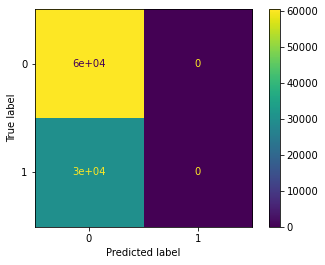

[[60496     0]
 [30012     0]]

Classification Accuracy:
0.6684050028726742
0.6684050028726742

Classification Error:
0.33159499712732576
0.33159499712732576

Sensitivity:
0.0
0.0

Specificity:
1.0

False Positivity Rate:
0.0
0.0

Precision:
nan
0.0


2018 MLB SEASON MODEL:


The Null Accuracy:
B    0.665881
S    0.334119
Name: result, dtype: float64

<ipython-input-113-14459e878ae4>:96: RuntimeWarning: invalid value encountered in true_divide
  precision = TP / float(TP + FP)
C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




We will create a model WITH CUSTOM SELECTION OF FEATURES.

(271591, 2) (90531, 2) (271591,) (90531,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   37.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   53.0s finished


Train score for 2018 season: 0.6663659694172487
Test score for 2018 season: 0.6644243408335266
The best parameters for the model were {'n_estimators': 250, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 3}
The accuracy score for 2018 is 0.6644243408335266


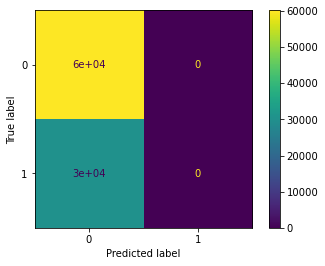

[[60151     0]
 [30380     0]]

Classification Accuracy:
0.6644243408335266
0.6644243408335266

Classification Error:
0.33557565916647336
0.33557565916647336

Sensitivity:
0.0
0.0

Specificity:
1.0

False Positivity Rate:
0.0
0.0

Precision:
nan
0.0


2019 MLB SEASON MODEL:


The Null Accuracy:
B    0.671056
S    0.328944
Name: result, dtype: float64


<ipython-input-113-14459e878ae4>:96: RuntimeWarning: invalid value encountered in true_divide
  precision = TP / float(TP + FP)
C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se


We will create a model WITH CUSTOM SELECTION OF FEATURES.



<ipython-input-113-14459e878ae4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_throws'] = np.where(df['p_throws'] == 'R', 1, 0)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


(272889, 2) (90963, 2) (272889,) (90963,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   35.6s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   50.7s finished


Train score for 2019 season: 0.6707232611061641
Test score for 2019 season: 0.6720534722909315
The best parameters for the model were {'n_estimators': 250, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 3}
The accuracy score for 2019 is 0.6720534722909315


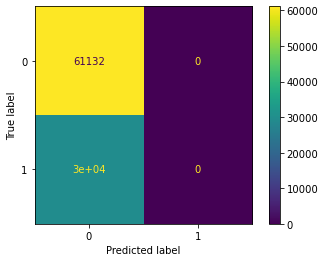

[[61132     0]
 [29831     0]]

Classification Accuracy:
0.6720534722909315
0.6720534722909315

Classification Error:
0.3279465277090685
0.3279465277090685

Sensitivity:
0.0
0.0

Specificity:
1.0

False Positivity Rate:
0.0
0.0

Precision:
nan
0.0


2020 MLB SEASON MODEL:


The Null Accuracy:
B    0.669815
S    0.330185
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.



<ipython-input-113-14459e878ae4>:96: RuntimeWarning: invalid value encountered in true_divide
  precision = TP / float(TP + FP)
C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(106183, 2) (35395, 2) (106183,) (35395,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   12.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   18.0s finished


Train score for 2020 season: 0.6689677255304521
Test score for 2020 season: 0.6723548523802797
The best parameters for the model were {'n_estimators': 250, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 3}
The accuracy score for 2020 is 0.6723548523802797


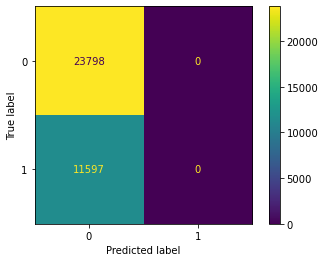

[[23798     0]
 [11597     0]]

Classification Accuracy:
0.6723548523802797
0.6723548523802797

Classification Error:
0.3276451476197203
0.3276451476197203

Sensitivity:
0.0
0.0

Specificity:
1.0

False Positivity Rate:
0.0
0.0

Precision:
nan
0.0


2021 MLB SEASON MODEL:


The Null Accuracy:
B    0.670057
S    0.329943
Name: result, dtype: float64


<ipython-input-113-14459e878ae4>:96: RuntimeWarning: invalid value encountered in true_divide
  precision = TP / float(TP + FP)
C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



We will create a model WITH CUSTOM SELECTION OF FEATURES.

(267784, 2) (89262, 2) (267784,) (89262,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   33.9s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:   48.8s finished


Train score for 2021 season: 0.6698570489648373
Test score for 2021 season: 0.6706549259483319
The best parameters for the model were {'n_estimators': 250, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 3}
The accuracy score for 2021 is 0.6706549259483319


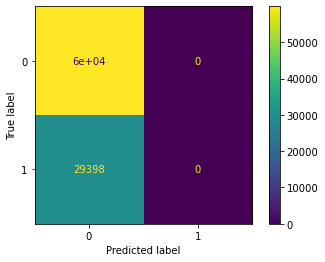

[[59864     0]
 [29398     0]]

Classification Accuracy:
0.6706549259483319
0.6706549259483319

Classification Error:
0.32934507405166813
0.32934507405166813

Sensitivity:
0.0
0.0

Specificity:
1.0

False Positivity Rate:
0.0
0.0

Precision:
nan
0.0


<ipython-input-113-14459e878ae4>:96: RuntimeWarning: invalid value encountered in true_divide
  precision = TP / float(TP + FP)
C:\Users\ncesm\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
seasons = [mlb15, mlb16, mlb17, mlb18, mlb19, mlb20, mlb21]
year = 2015
params = ({
    'n_estimators':[100,150,200,250],
    'max_depth':[2,3,4,5,None],
    'min_samples_split':[2,3,4],
    'max_features':['log2','auto']
})
for szn in seasons:
    rf_custom(szn, year, params, features=['stand', 'p_throws'], options='custom')
    year += 1

In [117]:
mlb15.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'stand', 'p_throws',
       'result', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'release_spin_rate', 'pitch_name'],
      dtype='object')



2015 MLB SEASON MODEL:


The Null Accuracy:
B    0.659733
S    0.340267
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(249064, 8) (83022, 8) (249064,) (83022,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.2min finished


Train score for 2015 season: 0.9997390229017441
Test score for 2015 season: 0.914480499144805
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2015 is 0.914480499144805


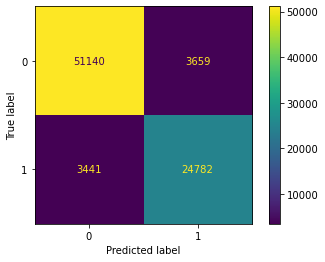

[[51140  3659]
 [ 3441 24782]]

Classification Accuracy:
0.914480499144805
0.914480499144805

Classification Error:
0.08551950085519501
0.085519500855195

Sensitivity:
0.8780781632002268
0.8780781632002268

Specificity:
0.9332287085530758

False Positivity Rate:
0.06677129144692422
0.06677129144692417

Precision:
0.8713477022608207
0.8713477022608207


2016 MLB SEASON MODEL:


The Null Accuracy:
B    0.661719
S    0.338281
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(253597, 8) (84533, 8) (253597,) (84533,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.6min finished


Train score for 2016 season: 0.9996727090620157
Test score for 2016 season: 0.9166952551074729
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2016 is 0.9166952551074729


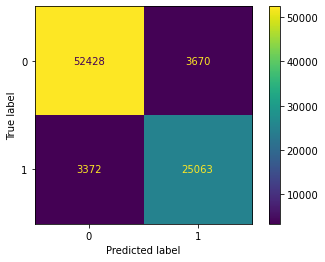

[[52428  3670]
 [ 3372 25063]]

Classification Accuracy:
0.9166952551074729
0.9166952551074729

Classification Error:
0.08330474489252718
0.08330474489252715

Sensitivity:
0.8814137506593986
0.8814137506593986

Specificity:
0.9345787728617776

False Positivity Rate:
0.06542122713822239
0.0654212271382224

Precision:
0.8722723001426931
0.8722723001426931


2017 MLB SEASON MODEL:


The Null Accuracy:
B    0.667877
S    0.332123
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org


We will create a model WITH CUSTOM SELECTION OF FEATURES.



<ipython-input-113-14459e878ae4>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-113-14459e878ae4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_throws'] = np.where(df['p_throws'] == 'R', 1, 0)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


(271523, 8) (90508, 8) (271523,) (90508,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.6min finished


Train score for 2017 season: 0.999639072933048
Test score for 2017 season: 0.9156317673575817
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2017 is 0.9156317673575817


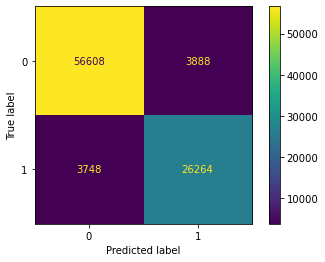

[[56608  3888]
 [ 3748 26264]]

Classification Accuracy:
0.9156317673575817
0.9156317673575817

Classification Error:
0.08436823264241836
0.08436823264241833

Sensitivity:
0.8751166200186592
0.8751166200186592

Specificity:
0.9357312880190426

False Positivity Rate:
0.06426871198095742
0.0642687119809574

Precision:
0.8710533297957018
0.8710533297957018


2018 MLB SEASON MODEL:


The Null Accuracy:
B    0.665881
S    0.334119
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(271591, 8) (90531, 8) (271591,) (90531,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.5min finished


Train score for 2018 season: 0.9996943934077345
Test score for 2018 season: 0.9217395146413936
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2018 is 0.9217395146413936


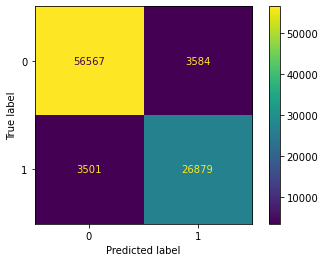

[[56567  3584]
 [ 3501 26879]]

Classification Accuracy:
0.9217395146413936
0.9217395146413936

Classification Error:
0.07826048535860644
0.07826048535860641

Sensitivity:
0.8847597103357472
0.8847597103357472

Specificity:
0.9404166181775864

False Positivity Rate:
0.05958338182241359
0.05958338182241363

Precision:
0.8823490792108459
0.8823490792108459


2019 MLB SEASON MODEL:


The Null Accuracy:
B    0.671056
S    0.328944
Name: result, dtype: float64


<ipython-input-11-14f528666e86>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-11-14f528666e86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-11-14f528666e86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org


We will create a model WITH CUSTOM SELECTION OF FEATURES.



<ipython-input-113-14459e878ae4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = np.where(df['result'] == 'S', 1, 0)
<ipython-input-113-14459e878ae4>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stand'] = np.where(df['stand'] == 'R', 1, 0)
<ipython-input-113-14459e878ae4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

(272889, 8) (90963, 8) (272889,) (90963,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.5min finished


Train score for 2019 season: 0.9997031760166222
Test score for 2019 season: 0.9248595582819388
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2019 is 0.9248595582819388


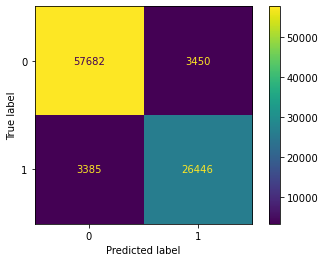

[[57682  3450]
 [ 3385 26446]]

Classification Accuracy:
0.9248595582819388
0.9248595582819388

Classification Error:
0.0751404417180612
0.07514044171806122

Sensitivity:
0.886527437900171
0.886527437900171

Specificity:
0.9435647451416607

False Positivity Rate:
0.056435254858339334
0.056435254858339334

Precision:
0.8845999464811346
0.8845999464811346


2020 MLB SEASON MODEL:


The Null Accuracy:
B    0.669815
S    0.330185
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(106183, 8) (35395, 8) (106183,) (35395,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   53.7s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  1.2min finished


Train score for 2020 season: 0.9997551397116299
Test score for 2020 season: 0.9270800960587654
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2020 is 0.9270800960587654


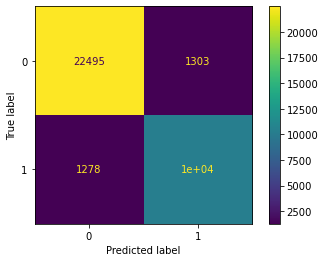

[[22495  1303]
 [ 1278 10319]]

Classification Accuracy:
0.9270800960587654
0.9270800960587654

Classification Error:
0.07291990394123464
0.0729199039412346

Sensitivity:
0.8897990859705096
0.8897990859705096

Specificity:
0.9452474997898983

False Positivity Rate:
0.05475250021010169
0.054752500210101696

Precision:
0.8878850456031664
0.8878850456031664


2021 MLB SEASON MODEL:


The Null Accuracy:
B    0.670057
S    0.329943
Name: result, dtype: float64

We will create a model WITH CUSTOM SELECTION OF FEATURES.

(267784, 8) (89262, 8) (267784,) (89262,)
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  3.5min finished


Train score for 2021 season: 0.9996228303408717
Test score for 2021 season: 0.9258811140238847
The best parameters for the model were {'n_estimators': 100, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': None}
The accuracy score for 2021 is 0.9258811140238847


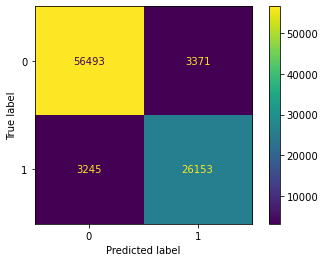

[[56493  3371]
 [ 3245 26153]]

Classification Accuracy:
0.9258811140238847
0.9258811140238847

Classification Error:
0.07411888597611525
0.07411888597611527

Sensitivity:
0.8896183413837676
0.8896183413837676

Specificity:
0.9436890284645196

False Positivity Rate:
0.056310971535480425
0.05631097153548037

Precision:
0.8858217043761007
0.8858217043761007


In [118]:
seasons = [mlb15, mlb16, mlb17, mlb18, mlb19, mlb20, mlb21]
year = 2015
params = ({
    'n_estimators':[100,150,200,250],
    'max_depth':[2,3,4,5,None],
    'min_samples_split':[2,3,4],
    'max_features':['log2','auto']
})
for szn in seasons:
    rf_custom(szn, year, params, features=['release_speed','release_pos_x', 'release_pos_z','pfx_x', 'pfx_z', 'plate_x',
       'plate_z','release_spin_rate'], options='custom')
    year += 1